In [1]:
import seaborn as sns
sns.set()
import altair as alt

In [2]:
import numpy as np
import pandas as pd
from numpy import random as rd
import tensorflow as tf
from tensorflow import keras

from sklearn.compose import ColumnTransformer

# SQLite and Data Preprocessing 


### SQL to Dataframe  

In [3]:

import sqlalchemy
from sqlalchemy import create_engine

from sqlalchemy import inspect


In [4]:
engine = create_engine("sqlite:///microstructures.sqlite")

In [5]:
MicrostrucureData = sqlalchemy.MetaData(bind = engine)

In [6]:
conn = engine.connect()

In [7]:
inspector = inspect(engine)

In [24]:

for table_name in inspector.get_table_names():
   for column in inspector.get_columns(table_name):
       print("Table: %s" % table_name , " Column: %s" % column['name'])
        

In [8]:
#### JOINS the micrograph table to the sample data table


micrographs = """

SELECT *
FROM micrograph JOIN sample ON sample_id = sample_key


"""

In [9]:
###  This is the main dataframe
micrographs_df =pd.read_sql_query(micrographs, conn)

In [11]:

micrographs_df.head()

,micrograph_id,path,micron_bar,micron_bar_units,micron_bar_px,magnification,detector,sample_key,contributor_key,primary_microconstituent,sample_id,label,anneal_time,anneal_time_unit,anneal_temperature,anneal_temp_unit,cool_method
0,1,micrograph1.tif,5.0,um,129,4910x,SE,42,2,pearlite,42,ET Gyro,NaN,None,NaN,None,None
1,2,micrograph2.tif,10.0,um,103,1964X,SE,18,2,spheroidite,18,AC1 800C 85H WQ,85.0,H,800.0,C,WQ
2,4,micrograph4.tif,10.0,um,129,None,SE,35,2,pearlite+spheroidite,35,AC1 970C 90M FC,90.0,M,970.0,C,FC
3,5,micrograph5.tif,5.0,um,129,4910X,SE,10,2,pearlite,10,AC1 750C 5M WQ,5.0,M,750.0,C,WQ
4,6,micrograph6.tif,20.0,um,124,1178X,SE,29,2,spheroidite,29,AC1 970C 90M AR,90.0,M,970.0,C,AR


Above we see that the main features are:\
&emsp; magnification\
&emsp; primary_microconstituent\
&emsp; anneal_time (along with anneal_time_unit)\
&emsp; anneal_temp\
&emsp; cool_method
    

### Custom Transformers for Data Preprocessing

The anneal time is in minutes and hours, and we will convert evething to minutes.\
The anneal temperature is Celsius which is bad for scaling so we will convert to Kelvin

In [10]:
from sklearn.base import BaseEstimator,TransformerMixin

In [11]:
class ToKelvin(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y= None):
        return self
        
    def transform(self, X, y = None):
        return X + 273.15
    

In [12]:
class ToMinute(BaseEstimator, TransformerMixin):
    
    def __init__(self, dataseries):
        self.dataseries = dataseries
        self.multi = self.dataseries.apply(self._M_to_K)
        
    def _M_to_K(self, char):
        if char == 'H':
            return 60
        if char == 'M':
            return 1
        else: 
            return 0
        
    def fit(self,X,y = None):
        return self
    
    
    def transform(self, X, y = None):
        
        return np.log(X*self.multi)
    

In [13]:
class ToMinuteOnly(BaseEstimator, TransformerMixin):
    
    def __init__(self, dataseries):
        self.dataseries = dataseries
        self.multi = self.dataseries.apply(self._M_to_K)
        
    def _M_to_K(self, char):
        if char == 'H':
            return 60
        if char == 'M':
            return 1
        else: 
            return 0
        
    def fit(self,X,y = None):
        return self
    
    
    def transform(self, X, y = None):
        
        return X*self.multi
    

## This is our main preprocssing dataframe

In [14]:
###  This is our main data frame before preprocessing

preprocess_micrographs_df = micrographs_df[['path',
                                 'sample_id',
                                 'anneal_time',
                                 'anneal_time_unit',
                                 'anneal_temperature','cool_method'
                                ]]

In [15]:
#convert to Kelvin

preprocess_micrographs_df['anneal_temperature_Kelvin'] = preprocess_micrographs_df['anneal_temperature'] + 273.15

C:\Users\Owner\AppData\Local\Temp\ipykernel_15564\2128548814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_micrographs_df['anneal_temperature_Kelvin'] = preprocess_micrographs_df['anneal_temperature'] + 273.15


In [640]:
preprocess_micrographs_df['anneal_temperature_Kelvin']

0          NaN
1      1073.15
2      1243.15
3      1023.15
4      1243.15
        ...   
798        NaN
799    1243.15
800    1243.15
801        NaN
802     973.15
Name: anneal_temperature_Kelvin, Length: 803, dtype: float64

In [16]:
to_minute = ToMinute(preprocess_micrographs_df['anneal_time_unit'])

preprocess_micrographs_df['anneal_time_minutes'] = to_minute.transform(preprocess_micrographs_df['anneal_time'])

C:\Users\Owner\AppData\Local\Temp\ipykernel_15564\3041493192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preprocess_micrographs_df['anneal_time_minutes'] = to_minute.transform(preprocess_micrographs_df['anneal_time'])


## This is our main data frame

In [17]:
# this is our main micrograph data frame. 
# It contains the file paths, sample_ids (for balancing), temerature in Kelvin, and time in minutes

main_micrographs_df = preprocess_micrographs_df[['path',
                                                 'sample_id', 
                                                 'anneal_temperature_Kelvin', 
                                                 'anneal_time_minutes','cool_method']]

In [672]:
main_micrographs_df['anneal_temperature_Kelvin']

0          NaN
1      1073.15
2      1243.15
3      1023.15
4      1243.15
        ...   
798        NaN
799    1243.15
800    1243.15
801        NaN
802     973.15
Name: anneal_temperature_Kelvin, Length: 803, dtype: float64

## Train-Test Split 

We are splitting on sample_id with a stratified split to deal with imbalances.



In [18]:
from sklearn.model_selection import train_test_split



In [674]:
train_main, test_main = train_test_split(main_micrographs_df, 
                                         test_size = 0.1, 
                                         stratify = main_micrographs_df['sample_id'], 
                                         random_state = 23)

Replace NaN with 'Not Annealed' Label for classification task.

In [675]:
train_class = train_main.copy().fillna('Not Annealed')
test_class = test_main.copy().fillna('Not Annealed')

In [676]:
train_class

,path,sample_id,anneal_temperature_Kelvin,anneal_time_minutes,cool_method
480,micrograph1035.tif,4,1273.15,1.609438,WQ
676,micrograph1441.tif,31,1243.15,4.49981,FC
761,micrograph1638.tif,47,Not Annealed,Not Annealed,Not Annealed
698,micrograph1500.tif,34,1243.15,1.609438,FC
493,micrograph1059.tif,17,1073.15,8.536996,Q
...,...,...,...,...,...
378,micrograph821.tif,32,1243.15,4.49981,WC
61,micrograph119.tif,35,1243.15,4.49981,FC
204,micrograph421.tif,47,Not Annealed,Not Annealed,Not Annealed
422,micrograph918.tif,47,Not Annealed,Not Annealed,Not Annealed


In [682]:
train_str = str(train_class['anneal_temperature_Kelvin']) + '_' + str(train_class['anneal_time_minutes'])
test_str= str(test_class['anneal_temperature_Kelvin']) + '_' + str(test_class['anneal_time_minutes'])

In [688]:
train_class['time_temp']=train_class.apply(lambda x:'%s_%s' % (x['anneal_temperature_Kelvin'],x['anneal_time_minutes']),axis=1)
test_class['time_temp']=test_class.apply(lambda x:'%s_%s' % (x['anneal_temperature_Kelvin'],x['anneal_time_minutes']),axis=1)

In [678]:
train_class['time_temp'] = str(train_class['anneal_temperature_Kelvin']) + '_' + str(train_class.loc['anneal_time_minutes'])
test_class['time_temp'] = str(test_class['anneal_temperature_Kelvin']) + '_' + str(test_class.loc['anneal_time_minutes'])

KeyError: 'anneal_temperature_Kelvin'

In [686]:
train_class

,path,sample_id,anneal_temperature_Kelvin,anneal_time_minutes,cool_method,time_temp
480,micrograph1035.tif,4,1273.15,1.609438,WQ,1273.15_1.6094379124341003
676,micrograph1441.tif,31,1243.15,4.49981,FC,1243.15_4.499809670330265
761,micrograph1638.tif,47,Not Annealed,Not Annealed,Not Annealed,Not Annealed_Not Annealed
698,micrograph1500.tif,34,1243.15,1.609438,FC,1243.15_1.6094379124341003
493,micrograph1059.tif,17,1073.15,8.536996,Q,1073.15_8.536995818712418
...,...,...,...,...,...,...
378,micrograph821.tif,32,1243.15,4.49981,WC,1243.15_4.499809670330265
61,micrograph119.tif,35,1243.15,4.49981,FC,1243.15_4.499809670330265
204,micrograph421.tif,47,Not Annealed,Not Annealed,Not Annealed,Not Annealed_Not Annealed
422,micrograph918.tif,47,Not Annealed,Not Annealed,Not Annealed,Not Annealed_Not Annealed


Drop Nan rows for regression tastk

In [120]:
train_regression_preweight = train_main.copy().dropna()
test_regression_preweight = test_main.copy().dropna()

In [649]:
test_regression_preweight['anneal_temperature_Kelvin']

455    1243.15
462    1173.15
430    1173.15
541    1243.15
167    1243.15
        ...   
6      1243.15
505    1073.15
285    1073.15
101    1243.15
548    1243.15
Name: anneal_temperature_Kelvin, Length: 61, dtype: float64

## Class Weights and StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler

In [25]:
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = train_class['sample_id'].unique(),
                                     y = train_class['sample_id'])

CLASS_WEIGHTS = dict(zip(train_class['sample_id'].unique(),class_weights))

For Regression we use sample weights on 'sample_id' and the StandardsScaler on temperature and time

In [130]:
sample_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = train_regression_preweight['sample_id'].unique(),
                                     y = train_regression_preweight['sample_id'])

SAMPLE_WEIGHTS = pd.DataFrame(zip(train_regression_preweight['sample_id'].unique(),sample_weights), columns = ['sample_id','sample_weights'])

In [131]:
train_regression_weights = pd.merge(train_regression_preweight, SAMPLE_WEIGHTS, on = 'sample_id')
test_regression_weights = pd.merge(test_regression_preweight, SAMPLE_WEIGHTS, on = 'sample_id')

In [125]:
train_regression_weights['inverse_anneal_temperature_Kelvin'] = 1/train_regression_weights['anneal_temperature_Kelvin']

In [126]:
test_regression_weights['inverse_anneal_temperature_Kelvin'] = 1/test_regression_weights['anneal_temperature_Kelvin']

In [31]:
train_regression_weights['log_log_time'] = np.log(train_regression_weights['anneal_time_minutes'])
test_regression_weights['log_log_time'] = np.log(test_regression_weights['anneal_time_minutes'])

In [32]:
ColScaler = ColumnTransformer([('scaler',StandardScaler(),[
                                                           'anneal_time_minutes',
                                                           
                                                          ])], 
                              remainder = 'passthrough')

ColScaler.set_output(transform ='pandas')

train_regression = ColScaler.fit_transform(train_regression_weights)

train_regression.rename(columns ={'remainder__path':'path', 
                         'remainder__sample_id':'sample_id', 
                         'remainder__sample_weights':'sample_weights'}, inplace = True)

In [33]:
test_regression = ColScaler.transform(test_regression_weights)
test_regression.rename(columns ={'remainder__path':'path', 
                         'remainder__sample_id':'sample_id', 
                         'remainder__sample_weights':'sample_weights'}, inplace = True)

In [434]:

train_regression_weights['scaled temperature'] = train_regression_weights['anneal_temperature_Kelvin']/train_regression_weights['anneal_temperature_Kelvin'].max()
train_regression = train_regression_weights[['path','sample_id','scaled temperature', 'anneal_time_minutes', 'sample_weights']]

In [435]:
test_regression_weights['scaled temperature'] = test_regression_weights['anneal_temperature_Kelvin']/train_regression_weights['anneal_temperature_Kelvin'].max()
test_regression = test_regression_weights[['path','sample_id','scaled temperature', 'anneal_time_minutes', 'sample_weights']]

In [369]:
train_regression.head(20)

,scaler__inverse_anneal_temperature_Kelvin,scaler__anneal_time_minutes,path,sample_id,remainder__anneal_temperature_Kelvin,sample_weights
0,-0.922779,-1.834467,micrograph1035.tif,4,1273.15,1.116424
1,-0.922779,-1.834467,micrograph133.tif,4,1273.15,1.116424
2,-0.922779,-1.834467,micrograph1173.tif,4,1273.15,1.116424
3,-0.922779,-1.834467,micrograph26.tif,4,1273.15,1.116424
4,-0.922779,-1.834467,micrograph191.tif,4,1273.15,1.116424
5,-0.922779,-1.834467,micrograph384.tif,4,1273.15,1.116424
6,-0.922779,-1.834467,micrograph893.tif,4,1273.15,1.116424
7,-0.922779,-1.834467,micrograph816.tif,4,1273.15,1.116424
8,-0.922779,-1.834467,micrograph884.tif,4,1273.15,1.116424
9,-0.922779,-1.834467,micrograph967.tif,4,1273.15,1.116424


In [445]:
np.exp(480)

2.8930191842539453e+208

In [370]:
train_regression_weights

,path,sample_id,anneal_temperature_Kelvin,anneal_time_minutes,sample_weights,inverse_anneal_temperature_Kelvin,log_log_time
0,micrograph1035.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
1,micrograph133.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
2,micrograph1173.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
3,micrograph26.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
4,micrograph191.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
...,...,...,...,...,...,...,...
532,micrograph1193.tif,27,1243.15,7.965546,2.902703,0.000804,2.075125
533,micrograph999.tif,27,1243.15,7.965546,2.902703,0.000804,2.075125
534,micrograph162.tif,27,1243.15,7.965546,2.902703,0.000804,2.075125
535,micrograph138.tif,27,1243.15,7.965546,2.902703,0.000804,2.075125


In [36]:
train_time_regression_weights_cribbed= train_regression_weights.loc[(train_regression_weights['anneal_time_minutes'] >= 1.4) & (train_regression_weights['anneal_time_minutes'] <= 2.95)]

In [37]:
test_time_regression_weights_cribbed= test_regression_weights.loc[(test_regression_weights['anneal_time_minutes'] >= 1.4) & (test_regression_weights['anneal_time_minutes'] <= 2.95)]

In [38]:
train_time_regression_weights_cribbed

,path,sample_id,anneal_temperature_Kelvin,anneal_time_minutes,sample_weights,inverse_anneal_temperature_Kelvin,log_log_time
0,micrograph1035.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
1,micrograph133.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
2,micrograph1173.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
3,micrograph26.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
4,micrograph191.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885
...,...,...,...,...,...,...,...
482,micrograph13.tif,8,1073.15,1.609438,2.073359,0.000932,0.475885
483,micrograph1078.tif,8,1073.15,1.609438,2.073359,0.000932,0.475885
484,micrograph659.tif,8,1073.15,1.609438,2.073359,0.000932,0.475885
485,micrograph1300.tif,8,1073.15,1.609438,2.073359,0.000932,0.475885


In [450]:
test_time_regression_weights_cribbed

,path,sample_id,anneal_temperature_Kelvin,anneal_time_minutes,sample_weights,inverse_anneal_temperature_Kelvin,log_log_time
0,micrograph995.tif,34,1243.15,1.609438,0.439803,0.000804,0.475885
1,micrograph1019.tif,34,1243.15,1.609438,0.439803,0.000804,0.475885
2,micrograph1573.tif,34,1243.15,1.609438,0.439803,0.000804,0.475885
3,micrograph221.tif,34,1243.15,1.609438,0.439803,0.000804,0.475885
10,micrograph1605.tif,8,1073.15,1.609438,2.073359,0.000932,0.475885
55,micrograph37.tif,38,1243.15,1.609438,1.451351,0.000804,0.475885
56,micrograph403.tif,9,973.15,1.609438,1.451351,0.001028,0.475885
57,micrograph1262.tif,4,1273.15,1.609438,1.116424,0.000785,0.475885


## Cribbed data set


In [23]:
to_minute_only = ToMinuteOnly(preprocess_micrographs_df['anneal_time_unit'])

minute_micrograph = preprocess_micrographs_df.copy()
minute_micrograph['anneal_time_minutes'] = to_minute_only.transform(preprocess_micrographs_df['anneal_time'])

In [403]:
from sklearn.preprocessing import OneHotEncoder

In [404]:
minute_micrograph.head()

,path,sample_id,anneal_time,anneal_time_unit,anneal_temperature,cool_method,anneal_time_minutes,anneal_temperature_Kelvin
0,micrograph1.tif,42,NaN,None,NaN,None,NaN,NaN
1,micrograph2.tif,18,85.0,H,800.0,WQ,5100.0,1073.15
2,micrograph4.tif,35,90.0,M,970.0,FC,90.0,1243.15
3,micrograph5.tif,10,5.0,M,750.0,WQ,5.0,1023.15
4,micrograph6.tif,29,90.0,M,970.0,AR,90.0,1243.15


In [1156]:
cribbed_micrographs_precut =  minute_micrograph.loc[(minute_micrograph['anneal_time_minutes'] >= 90) & (minute_micrograph['anneal_time_minutes'] <= 180)]

In [1157]:
cribbed_micrographs = cribbed_micrographs_precut[['path',
                                                 'sample_id', 
                                                 'anneal_temperature_Kelvin', 
                                                 'anneal_time_minutes','cool_method']]

In [1158]:
cribbed_micrographs['log_time'] = cribbed_micrographs['anneal_time_minutes'].apply(lambda x : np.log(x))

C:\Users\Owner\AppData\Local\Temp\ipykernel_3292\3331577312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cribbed_micrographs['log_time'] = cribbed_micrographs['anneal_time_minutes'].apply(lambda x : np.log(x))


In [1159]:
cribbed_micrographs['log_log_time'] = cribbed_micrographs['log_time'].apply(lambda x : np.log(x))

C:\Users\Owner\AppData\Local\Temp\ipykernel_3292\883127929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cribbed_micrographs['log_log_time'] = cribbed_micrographs['log_time'].apply(lambda x : np.log(x))


In [1160]:
cribbed_micrographs['inverse_anneal_temperature_Kelvin'] = 1/cribbed_micrographs['anneal_temperature_Kelvin']

In [1161]:
cribbed_micrographs['log_t_inverse_anneal_temperature_Kelvin'] = cribbed_micrographs['inverse_anneal_temperature_Kelvin']/cribbed_micrographs['log_time']

In [1162]:
cribbed_micrographs['inverse_log_t_anneal_temperature_Kelvin'] =cribbed_micrographs['log_t_inverse_anneal_temperature_Kelvin'].apply(lambda x: np.log(1+x))

In [408]:
cribbed_micrographs['cool_method'].nunique()

7

In [1739]:
ColCribbedScaler = ColumnTransformer([('scaler',StandardScaler(),['anneal_temperature_Kelvin',
                                                           'log_time','log_log_time','log_t_inverse_anneal_temperature_Kelvin'
                                                          ])], 
                              remainder = 'passthrough')


In [1166]:
cribbed_micrographs_

,path,sample_id,anneal_temperature_Kelvin,anneal_time_minutes,cool_method,log_time,log_log_time,inverse_anneal_temperature_Kelvin,log_t_inverse_anneal_temperature_Kelvin,inverse_log_t_anneal_temperature_Kelvin,AR,FC,Q,WC,WQ,WQ-2C
2,micrograph4.tif,35,1243.15,90.0,FC,4.499810,1.504035,0.000804,0.000179,0.000179,0,1,0,0,0,0
4,micrograph6.tif,29,1243.15,90.0,AR,4.499810,1.504035,0.000804,0.000179,0.000179,1,0,0,0,0,0
5,micrograph7.tif,40,1243.15,90.0,Q,4.499810,1.504035,0.000804,0.000179,0.000179,0,0,1,0,0,0
6,micrograph8.tif,31,1243.15,90.0,FC,4.499810,1.504035,0.000804,0.000179,0.000179,0,1,0,0,0,0
7,micrograph9.tif,31,1243.15,90.0,FC,4.499810,1.504035,0.000804,0.000179,0.000179,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,micrograph1676.png,37,1243.15,180.0,Q,5.192957,1.647303,0.000804,0.000155,0.000155,0,0,1,0,0,0
777,micrograph1677.tif,26,1243.15,180.0,WQ,5.192957,1.647303,0.000804,0.000155,0.000155,0,0,0,0,1,0
788,micrograph1703.tif,19,1173.15,90.0,WQ,4.499810,1.504035,0.000852,0.000189,0.000189,0,0,0,0,1,0
790,micrograph1710.tif,35,1243.15,90.0,FC,4.499810,1.504035,0.000804,0.000179,0.000179,0,1,0,0,0,0


In [1741]:
ColCribbedScaler.set_output(transform ='pandas')

cribbed_presplit = ColCribbedScaler.fit_transform(cribbed_micrographs_)

In [1740]:
ohe = pd.get_dummies(cribbed_micrographs['cool_method'])
cribbed_micrographs_ = cribbed_micrographs.join(ohe)

In [1174]:
cribbed_presplit.head(1)

,scaler__inverse_anneal_temperature_Kelvin,scaler__log_time,scaler__log_log_time,scaler__log_t_inverse_anneal_temperature_Kelvin,remainder__path,remainder__sample_id,remainder__anneal_temperature_Kelvin,remainder__anneal_time_minutes,remainder__cool_method,remainder__inverse_log_t_anneal_temperature_Kelvin,remainder__AR,remainder__FC,remainder__Q,remainder__WC,remainder__WQ,remainder__WQ-2C
2,-0.601502,-0.760286,-0.760286,0.22201,micrograph4.tif,35,1243.15,90.0,FC,0.000179,0,1,0,0,0,0


In [1749]:
dummies_cribbed = [ 'remainder__AR', 'remainder__FC', 'remainder__Q', 'remainder__WC', 'remainder__WQ', 'remainder__WQ-2C']

In [1742]:
train_cribbed_preweight, test_cribbed_preweight = train_test_split(cribbed_presplit, 
                                         test_size = 0.1, 
                                         stratify = cribbed_presplit['remainder__sample_id'], 
                                         random_state = 23)

In [1744]:
sample_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = train_cribbed_preweight['remainder__sample_id'].unique(),
                                     y = train_cribbed_preweight['remainder__sample_id'])

SAMPLE_WEIGHTS = pd.DataFrame(zip(train_cribbed_preweight['remainder__sample_id'].unique(),sample_weights), columns = ['remainder__sample_id','sample_weights'])

In [1745]:
train_cribbed = pd.merge(train_cribbed_preweight, SAMPLE_WEIGHTS, on = 'remainder__sample_id')
test_cribbed = pd.merge(test_cribbed_preweight, SAMPLE_WEIGHTS, on = 'remainder__sample_id')

# Transfer Learning:  InceptionV3 Regeression model with stratified train test data


In [20]:


from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


In [884]:
train_cribbed

,scaler__anneal_temperature_Kelvin,scaler__log_time,remainder__path,remainder__sample_id,remainder__anneal_time_minutes,remainder__cool_method,remainder__650-1H,remainder__AR,remainder__FC,remainder__Q,remainder__WC,remainder__WQ,remainder__WQ-2C,sample_weights
0,2.184505,-1.372394,micrograph997.tif,5,60.0,650-1H,1,0,0,0,0,0,0,1.150000
1,2.184505,-1.372394,micrograph660.tif,5,60.0,650-1H,1,0,0,0,0,0,0,1.150000
2,2.184505,-1.372394,micrograph1206.tif,5,60.0,650-1H,1,0,0,0,0,0,0,1.150000
3,2.184505,-1.372394,micrograph677.tif,5,60.0,650-1H,1,0,0,0,0,0,0,1.150000
4,2.184505,-1.372394,micrograph481.tif,5,60.0,650-1H,1,0,0,0,0,0,0,1.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,-1.654733,-0.756570,micrograph419.tif,11,90.0,WQ,0,0,0,0,0,1,0,2.683333
318,-1.654733,-0.756570,micrograph1138.tif,11,90.0,WQ,0,0,0,0,0,1,0,2.683333
319,-1.654733,-0.756570,micrograph1405.tif,11,90.0,WQ,0,0,0,0,0,1,0,2.683333
320,-1.654733,-0.756570,micrograph1167.tif,11,90.0,WQ,0,0,0,0,0,1,0,2.683333


In [1750]:
CRIB_DATAFRAME = train_cribbed
DIRECTORY = 'micrographs'
CRIB_XCOL = 'remainder__path'
CRIB_YCOL = [ 'scaler__log_time','scaler__anneal_temperature_Kelvin'] + dummies_cribbed
TARGET_SIZE = (522,645)
BATCH_SIZE = 32
#['scaled temperature', 'anneal_time_minutes']

In [69]:

data_generator = ImageDataGenerator()

validation_generator = ImageDataGenerator()


In [1751]:
train_regression_cribbed = data_generator.flow_from_dataframe(dataframe = CRIB_DATAFRAME,
                                                directory = DIRECTORY,
                                                x_col = CRIB_XCOL,
                                                y_col = CRIB_YCOL,
                                                class_mode= 'raw',
                                                color_mode = 'rgb',
                                                sample_weights = 'remainder__sample_weights',
                                                target_size = TARGET_SIZE,
                                                batch_size = 32)

validation_regression_cribbed = validation_generator.flow_from_dataframe(dataframe = CRIB_DATAFRAME,
                                                directory = DIRECTORY,
                                                x_col = CRIB_XCOL,
                                                y_col = CRIB_YCOL,
                                                class_mode = 'raw',
                                                color_mode = 'rgb',
                                                sample_weights = 'remainder__sample_weights',
                                                target_size = TARGET_SIZE,
                                                batch_size = 32)

Found 245 validated image filenames.
Found 245 validated image filenames.


In [71]:
inception = keras.applications.inception_v3.InceptionV3(include_top = False, weights = 'imagenet', input_shape = (256,256,3))

In [72]:
for layer in inception.layers:
    layer.trainable = False

In [145]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)


In [1644]:
for layer in vgg19.layers:
    layer.trainable = False

In [1642]:
vgg19 = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
    

80134624/80134624 [==============================] - 2s 0us/step


In [1752]:
    
def inception_regression_model_builder(training_data):
    model = Sequential()
    
    model.add(tf.keras.Input(shape=(522,645,3)))
    model.add(layers.Rescaling(scale = 1./255))
    model.add(layers.Cropping2D(
              cropping=((0, 40), (0, 0))
                ))
    
    model.add(layers.RandomFlip())
    model.add(layers.RandomRotation(factor = 0.4, 
                                    fill_mode = 'reflect'))
    
    model.add(layers.RandomZoom(.4,.2))
    model.add(layers.RandomContrast(.2))          
    model.add(layers.RandomCrop(256,256))
    
    model.add(inception)
    model.add(layers.Flatten())
    
    model.add(layers.Dense(1500, activation = None))
 
    model.add(layers.BatchNormalization(momentum=.99))
    model.add(layers.Activation('relu'))
    
    model.add(layers.Dropout(.3))
    
              
    model.add(layers.Dense(1000, activation = None))
                           
    model.add(layers.BatchNormalization(momentum=.99))
    model.add(layers.Activation('relu'))
    
    model.add(layers.Dropout(.3))
    
    #model.add(layers.Dense(500, activation = 'relu',kernel_regularizer='l1_l2'))
    
    #model.add(layers.Dropout(.3))
    
    #model.add(layers.Dense(100, activation = 'relu',kernel_regularizer='l1_l2'))
    
    #model.add(layers.Dropout(.3))
    
    
    #model.add(layers.Dense(50, activation = 'relu',kernel_regularizer='l1_l2'))
    
    #model.add(layers.Dropout(.3))
    
 
    #model.add(layers.Dense(9, activation = 'relu',kernel_regularizer='l1_l2'))
    
    #model.add(layers.Dropout(.3))
    
    
    model.add(layers.Dense(8,kernel_regularizer='l1_l2'))
    
    model.compile(optimizer ='adam',
                loss ='mse',
                metrics=[tf.keras.metrics.mean_squared_error]
                 )
    
    
    model.summary()
    return model

#

In [1753]:
inception_regression_model = inception_regression_model_builder(train_regression_cribbed)


Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_74 (Rescaling)    (None, 522, 645, 3)       0         
                                                                 
 cropping2d_74 (Cropping2D)  (None, 482, 645, 3)       0         
                                                                 
 random_flip_74 (RandomFlip  (None, 482, 645, 3)       0         
 )                                                               
                                                                 
 random_rotation_74 (Random  (None, 482, 645, 3)       0         
 Rotation)                                                       
                                                                 
 random_zoom_73 (RandomZoom  (None, 482, 645, 3)       0         
 )                                                               
                                                     

In [1649]:
mse_hist = []
mse_valid_hist = []

In [1083]:
regression_callbacks = [
tf.keras.callbacks.EarlyStopping(patience=5, monitor = 'val_loss')
    #tf.keras.callbacks.ModelCheckpoint(filepath='inception_regression_model.{epoch:02d}-{val_loss:.2f}.keras', save_best_only = True),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ]


In [1754]:
#mse_hist = []
#mse_valid_hist = []



inception_regression_model_fit = inception_regression_model.fit(train_regression_cribbed,
                                                                steps_per_epoch = train_regression_cribbed.samples/BATCH_SIZE,
                                                                epochs = 20,
                                                                validation_data = validation_regression_cribbed,
                                                                validation_steps = validation_regression_cribbed.samples/BATCH_SIZE,
                                                                callbacks = None#regression_callbacks
                                                                )
    
#mse_hist += inception_regression_model_fit.history['mean_squared_error']
#mse_valid_hist +=inception_regression_model_fit.history['val_mean_squared_error']
    

Epoch 1/20
7/7 [==============================] - 28s 3s/step - loss: 5.1073 - mean_squared_error: 1.9612 - val_loss: 59.1547 - val_mean_squared_error: 56.1045
Epoch 2/20
7/7 [==============================] - 19s 3s/step - loss: 4.3335 - mean_squared_error: 1.3607 - val_loss: 31.9570 - val_mean_squared_error: 29.0874
Epoch 3/20
7/7 [==============================] - 19s 3s/step - loss: 3.7678 - mean_squared_error: 0.9737 - val_loss: 18.9196 - val_mean_squared_error: 16.2294
Epoch 4/20
7/7 [==============================] - 19s 3s/step - loss: 3.5016 - mean_squared_error: 0.8897 - val_loss: 13.2921 - val_mean_squared_error: 10.7774
Epoch 5/20
7/7 [==============================] - 19s 3s/step - loss: 3.1462 - mean_squared_error: 0.7085 - val_loss: 6.8220 - val_mean_squared_error: 4.4790
Epoch 6/20
7/7 [==============================] - 19s 3s/step - loss: 2.8403 - mean_squared_error: 0.5727 - val_loss: 4.1601 - val_mean_squared_error: 1.9829
Epoch 7/20
7/7 [============================

In [175]:
#inception_regression_model.save('one_layer_reg_model_1500_sgd_001_300epochs_linearT.keras')

In [1105]:
inception_regression_model.save('inverseT_t_linear_T_cribbed_cooling_L1L2_75_epochs50.keras')

In [1154]:
inception_regression_model.save('Demo_model.keras')

In [75]:
inception_regression_model = tf.keras.saving.load_model('log_t_linear_T_cribbed_50_epoch.keras')

In [1106]:
inception_regression_model.save_weights('weights_cache.h5')

In [176]:
inception_regression_model.save_weights('one_layer_reg_weights_1500_sgd_00epochs_linearT.h5')

In [47]:
inception_regression_model.load_weights('weights_cache.h5')

In [97]:
    
mse_hist += inception_regression_model_fit.history['mean_squared_error']
mse_valid_hist +=inception_regression_model_fit.history['val_mean_squared_error']
    

In [68]:
results_list = []

In [1755]:
test_datagenerator = ImageDataGenerator()

test_generator_cribbed = test_datagenerator.flow_from_dataframe(dataframe = test_cribbed,
                                                        directory = DIRECTORY,
                                                        x_col = CRIB_XCOL,
                                                        y_col = CRIB_YCOL,
                                                        class_mode = 'raw',
                                                        color_mode = 'rgb',
                                                        shuffle = False,
                                                        target_size = TARGET_SIZE,
                                                        batch_size = 1)




Found 28 validated image filenames.


In [1756]:
results = inception_regression_model.evaluate(test_generator_cribbed)
results_list_cribbed.append(results)

28/28 [==============================] - 3s 103ms/step - loss: 0.7136 - mean_squared_error: 0.2755


In [1058]:
results_list_cribbed  

[[151.082275390625, 1.0969688892364502],
 [137.3759765625, 1.0757368803024292],
 [129.7729949951172, 1.0565776824951172],
 [123.56736755371094, 1.0391508340835571],
 [127.28446197509766, 0.5790507197380066],
 [82.08528137207031, 0.3851509988307953],
 [77.98876190185547, 0.5015532970428467],
 [76.17292022705078, 0.49725306034088135],
 [75.9318618774414, 0.4029030501842499],
 [74.21504211425781, 0.41079965233802795],
 [121.38297271728516, 0.3447912931442261],
 [112.59080505371094, 0.33753299713134766],
 [102.68380737304688, 0.3304663300514221],
 [154.86085510253906, 0.33487236499786377],
 [231.44171142578125, 0.3409392833709717],
 0.09760744869709015,
 0.09760744869709015,
 0.09760744869709015,
 [443.527099609375, 0.41688287258148193],
 [352.7972106933594, 0.19877582788467407],
 [3.748805046081543, 1.3329620361328125],
 [1.5838892459869385, 0.20931242406368256],
 [0.6881129741668701, 0.09226873517036438],
 [0.28130608797073364, 0.08854416757822037],
 [0.16675254702568054, 0.0987165197730

In [1757]:
nb_samples = len(test_cribbed)

predict = inception_regression_model.predict(test_generator_cribbed,nb_samples)

28/28 [==============================] - 4s 101ms/step


In [614]:
#train_cribbed

In [589]:
train_cribbed.head()

,scaler__anneal_temperature_Kelvin,scaler__log_time,remainder__path,remainder__sample_id,remainder__anneal_time_minutes,sample_weights
0,2.184505,-1.372394,micrograph997.tif,5,60.0,1.15
1,2.184505,-1.372394,micrograph660.tif,5,60.0,1.15
2,2.184505,-1.372394,micrograph1206.tif,5,60.0,1.15
3,2.184505,-1.372394,micrograph677.tif,5,60.0,1.15
4,2.184505,-1.372394,micrograph481.tif,5,60.0,1.15


In [1758]:
r2_scores_cribbed = []

In [1760]:
temp_r2 = r2_score(test_cribbed['scaler__anneal_temperature_Kelvin'],predict[:,0])#, sample_weight = test_cribbed['sample_weights'])
time_r2 = r2_score(test_cribbed['scaler__log_time'],predict[:,1])#, sample_weight = test_cribbed['sample_weights'])
r2_scores_cribbed.append((temp_r2,time_r2))

In [1761]:
r2_scores_cribbed

[(-0.6352156556974131, -0.69390756566944)]

In [435]:
predict[:2][:]

array([[ 0.26264223,  0.27555406,  0.22255786, -0.08182403,  0.14036459,
         0.21282433, -0.0518166 ,  0.42647266,  0.312062  ],
       [ 0.0727222 ,  0.5444925 ,  0.3343601 , -0.12890686,  0.17180371,
         0.20074049, -0.09300104,  0.4945156 ,  0.2665058 ]],
      dtype=float32)

In [1111]:
predict_transform = ColCribbedScaler.named_transformers_['scaler'].inverse_transform(predict[:,:4])

In [615]:
#predict_transform

In [987]:
predict_transform_time = np.exp(predict_transform[:,1])

In [617]:
#test_regression_weights

In [91]:
test_cribbed_unscaled =  ColCribbedScaler.named_transformers_['scaler']\
                                         .inverse_transform(test_cribbed_preweight[['scaler__anneal_temperature_Kelvin',
                                                                                   'scaler__log_time']])

In [300]:
temps = test_cribbed_unscaled[:,0]
times = np.exp(test_cribbed_unscaled[:,1])
             #                           
test_cribbed_check = pd.DataFrame({'temperature':temps,'time': times})


In [1124]:
predict_df = pd.DataFrame(predict_transform[:,:2], columns = ['scaled_temperature','log_time'])
predict_df['time'] = predict_df['log_time'].apply(lambda x: np.exp(x))
predict_df['temp'] = predict_df['scaled_temperature'].apply(lambda x: 1/x)
predict_df['true temp'] =test_cribbed_check['temperature']
predict_df['true time'] = test_cribbed_check['time']
predict_df['image'] = test_cribbed['remainder__path']

In [1123]:
test_cribbed

,scaler__inverse_anneal_temperature_Kelvin,scaler__log_time,scaler__log_log_time,scaler__log_inverse_anneal_temperature_Kelvin,remainder__path,remainder__sample_id,remainder__anneal_temperature_Kelvin,remainder__anneal_time_minutes,remainder__cool_method,remainder__650-1H,remainder__AR,remainder__FC,remainder__Q,remainder__WC,remainder__WQ,remainder__WQ-2C,sample_weights
0,-0.547258,0.296189,0.367131,-0.547249,micrograph597.tif,26,1243.15,180.0,WQ,0,0,0,0,0,1,0,1.238462
1,-0.547258,-0.756570,-0.763746,-0.547249,micrograph1273.tif,33,1243.15,90.0,WQ-2C,0,0,0,0,0,0,1,0.700000
2,-0.547258,-0.756570,-0.763746,-0.547249,micrograph411.tif,33,1243.15,90.0,WQ-2C,0,0,0,0,0,0,1,0.700000
3,-0.547258,-0.756570,-0.763746,-0.547249,micrograph443.tif,32,1243.15,90.0,WC,0,0,0,0,1,0,0,1.006250
4,-0.547258,-0.756570,-0.763746,-0.547249,micrograph1280.tif,32,1243.15,90.0,WC,0,0,0,0,1,0,0,1.006250
5,1.710790,-0.756570,-0.763746,1.710769,micrograph584.tif,12,1073.15,90.0,WQ,0,0,0,0,0,1,0,2.012500
6,-0.547258,-0.756570,-0.763746,-0.547249,micrograph625.tif,29,1243.15,90.0,AR,0,1,0,0,0,0,0,0.894444
7,-0.547258,-0.756570,-0.763746,-0.547249,micrograph209.tif,29,1243.15,90.0,AR,0,1,0,0,0,0,0,0.894444
8,-0.547258,0.296189,0.367131,-0.547249,micrograph1032.png,37,1243.15,180.0,Q,0,0,0,1,0,0,0,0.392683
9,-0.547258,0.296189,0.367131,-0.547249,micrograph1611.tif,37,1243.15,180.0,Q,0,0,0,1,0,0,0,0.392683


In [874]:
mae_list = []

In [1113]:
temp_mae = mean_absolute_error(predict_df['temp'],test_cribbed_check['temperature'])
time_mae = mean_absolute_error(predict_df['time'],test_cribbed_check['time'])
mae_list.append((temp_mae,time_mae))

In [1114]:
mae_list

[(89.29688110351564, 102.24793132652273),
 (1200.093611363006, 117.99523208337511),
 (66.93401211927487, 117.99523208337511),
 (66.93401211927487, 117.99523208337511),
 (71.58220629131658, 122.95215023359151),
 (64.84416958193327, 108.6928311232945),
 (70.03860940881547, 126.58773242353635),
 (69.63750183660125, 121.93367202313028),
 (69.96444969457924, 132.70419840963416),
 (72.00988323644816, 121.40732885535681)]

In [99]:
mape_list = []

In [578]:
temp_mape = mean_absolute_percentage_error(predict_df['scaled_temperature'],test_cribbed_check['temperature'])
time_mape = mean_absolute_percentage_error(predict_df['time'],test_cribbed_check['time'])
mape_list.append((temp_mape,time_mape))

In [101]:
mape_list

[(0.06879694002444996, 0.9715388786818393)]

In [ ]:
chart3 = alt.Chart(predict_df_sorted).mark_point().encode(
    x = 'time',
    y = 'temp')

chart3.encoding.x.scale = alt.Scale(domain=[40, 200])
chart3.encoding.y.scale = alt.Scale(domain=[1000, 1400])
chart3

In [ ]:
chart4 =alt.Chart(predict_df_sorted).mark_point().encode(
    x = alt.X('true time'),
    y = alt.X('true temp'))

chart4.encoding.x.scale = alt.Scale(domain=[40, 200])
chart4.encoding.y.scale = alt.Scale(domain=[1000, 1400])
chart4

In [ ]:
import altair as alt

In [1152]:

chart2 = alt.Chart(predict_df_sorted).mark_point().encode(
    x = 'time',
    y = 'temp')

chart2.encoding.x.scale = alt.Scale(domain=[40, 200])
chart2.encoding.y.scale = alt.Scale(domain=[1000, 1400])
chart2

alt.Chart(...)

In [1153]:
chart =alt.Chart(predict_df_sorted).mark_point().encode(
    x = alt.X('true time'),
    y = alt.X('true temp'))

chart.encoding.x.scale = alt.Scale(domain=[40, 200])
chart.encoding.y.scale = alt.Scale(domain=[1000, 1400])
chart

alt.Chart(...)

In [1126]:
predict_df['score'] = ((predict_df['true time'] -predict_df['time'])**2 + (predict_df['true temp'] -predict_df['temp'])**2)**.5

In [1127]:
predict_df_sorted = predict_df.sort_values('score')

In [1142]:
predict_df_sorted.head(8) 

,scaled_temperature,log_time,time,temp,true temp,true time,image,score
6,0.000797,4.540570,93.744243,1255.098451,1243.15,90.0,micrograph625.tif,12.521376
2,0.000800,4.719900,112.156998,1249.546177,1243.15,90.0,micrograph411.tif,23.061735
29,0.000805,4.833427,125.640789,1242.068589,1243.15,90.0,micrograph779.tif,35.657191
9,0.000826,4.819660,123.922973,1210.175497,1173.15,90.0,micrograph1611.tif,50.216088
16,0.000799,4.940603,139.854592,1252.315430,1243.15,90.0,micrograph609.tif,50.690092
26,0.000880,4.828099,124.973132,1135.913118,1173.15,90.0,micrograph10.png,51.085276
34,0.000840,5.241171,188.891142,1190.752288,1243.15,180.0,micrograph907.tif,53.146708
25,0.000847,4.589553,98.450448,1180.786788,1243.15,90.0,micrograph1682.tif,62.933141


In [1128]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(predict_df_sorted)

,scaled_temperature,log_time,time,temp,true temp,true time,image,score
6,0.000797,4.540570,93.744243,1255.098451,1243.15,90.0,micrograph625.tif,12.521376
2,0.000800,4.719900,112.156998,1249.546177,1243.15,90.0,micrograph411.tif,23.061735
29,0.000805,4.833427,125.640789,1242.068589,1243.15,90.0,micrograph779.tif,35.657191
9,0.000826,4.819660,123.922973,1210.175497,1173.15,90.0,micrograph1611.tif,50.216088
16,0.000799,4.940603,139.854592,1252.315430,1243.15,90.0,micrograph609.tif,50.690092
26,0.000880,4.828099,124.973132,1135.913118,1173.15,90.0,micrograph10.png,51.085276
34,0.000840,5.241171,188.891142,1190.752288,1243.15,180.0,micrograph907.tif,53.146708
25,0.000847,4.589553,98.450448,1180.786788,1243.15,90.0,micrograph1682.tif,62.933141
5,0.000815,4.776600,118.700126,1227.678252,1243.15,180.0,micrograph584.tif,63.222224
7,0.000836,4.898605,134.102623,1196.398964,1243.15,90.0,micrograph209.tif,64.270527


<function matplotlib.pyplot.show(close=None, block=None)>

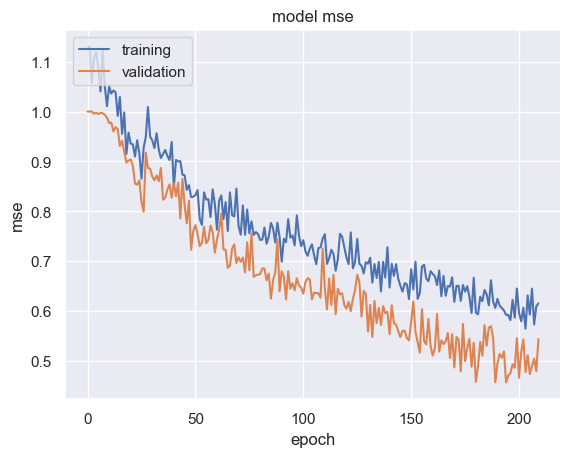

In [639]:
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(mse_hist[15:])
ax1.plot(mse_valid_hist[15:])
ax1.set_title('model mse')
ax1.set_xlabel('epoch')
ax1.set_ylabel('mse')
ax1.legend(['training', 'validation'], loc = 'upper left')

plt.show

In [115]:
mse_1_layer_hist = mse_hist
mse_1_layer_valid_hist = mse_valid_hist

<function matplotlib.pyplot.show(close=None, block=None)>

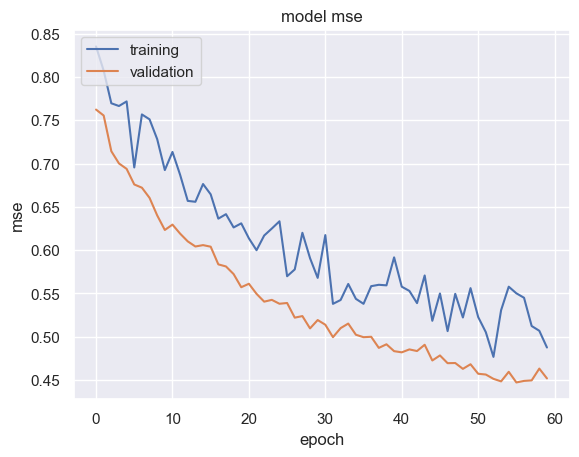

In [102]:
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(mse_hist)
ax1.plot(mse_valid_hist)
ax1.set_title('model mse')
ax1.set_xlabel('epoch')
ax1.set_ylabel('mse')
ax1.legend(['training', 'validation'], loc = 'upper left')

plt.show

In [89]:
from sklearn.metrics import classification_report

In [92]:
#classification report 

test_steps_per_epoch = np.math.ceil(validation_regression.samples / validation_regression.batch_size)
predictions = inception_regression_model.predict(validation_regression, steps=test_steps_per_epoch)
test_steps_per_epoch = np.math.ceil(validation_regression.samples / validation_regression.batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_regression.classes
class_labels = list(validation_regression.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   



17/17 [==============================] - 11s 626ms/step


AttributeError: 'DataFrameIterator' object has no attribute 'classes'

In [136]:
train_regression_weights.head()

,path,sample_id,anneal_temperature_Kelvin,anneal_time_minutes,sample_weights,inverse_anneal_temperature_Kelvin
0,micrograph1035.tif,4,1273.15,1.609438,1.116424,0.000785
1,micrograph133.tif,4,1273.15,1.609438,1.116424,0.000785
2,micrograph1173.tif,4,1273.15,1.609438,1.116424,0.000785
3,micrograph26.tif,4,1273.15,1.609438,1.116424,0.000785
4,micrograph191.tif,4,1273.15,1.609438,1.116424,0.000785


# Inverse Temp - Log time: Full Data Set

In [24]:
minute_micrograph

,path,sample_id,anneal_time,anneal_time_unit,anneal_temperature,cool_method,anneal_temperature_Kelvin,anneal_time_minutes
0,micrograph1.tif,42,NaN,None,NaN,None,NaN,NaN
1,micrograph2.tif,18,85.0,H,800.0,WQ,1073.15,5100.0
2,micrograph4.tif,35,90.0,M,970.0,FC,1243.15,90.0
3,micrograph5.tif,10,5.0,M,750.0,WQ,1023.15,5.0
4,micrograph6.tif,29,90.0,M,970.0,AR,1243.15,90.0
...,...,...,...,...,...,...,...,...
798,micrograph1723.tif,41,NaN,None,NaN,None,NaN,NaN
799,micrograph1726.tif,34,5.0,M,970.0,FC,1243.15,5.0
800,micrograph1730.png,40,90.0,M,970.0,Q,1243.15,90.0
801,micrograph1731.tif,47,NaN,None,NaN,None,NaN,NaN


In [25]:
train_regression_start = minute_micrograph[['path',
                                                 'sample_id', 
                                                 'anneal_temperature_Kelvin', 
                                                 'anneal_time_minutes','cool_method']].dropna()

In [26]:
train_regression_start['log_time'] = train_regression_start['anneal_time_minutes'].apply(lambda x : np.log(x))
train_regression_start['inverse_anneal_temperature_Kelvin'] = 1/train_regression_start['anneal_temperature_Kelvin']
train_regression_start['log_log_time'] = train_regression_start['log_time'].apply(lambda x : np.log(x))

train_regression_start['log_t_inverse_anneal_temperature_Kelvin'] = train_regression_start['inverse_anneal_temperature_Kelvin']/train_regression_start['log_time']

train_regression_start['inverse_log_t_anneal_temperature_Kelvin'] =train_regression_start['log_t_inverse_anneal_temperature_Kelvin'].apply(lambda x: np.log(1+x))




In [1208]:
regression_data.head()

,scaler__inverse_anneal_temperature_Kelvin,scaler__anneal_time_minutes,path,sample_id,remainder__anneal_temperature_Kelvin,sample_weights
0,-0.922779,-1.834467,micrograph1035.tif,4,1273.15,1.116424
1,-0.922779,-1.834467,micrograph133.tif,4,1273.15,1.116424
2,-0.922779,-1.834467,micrograph1173.tif,4,1273.15,1.116424
3,-0.922779,-1.834467,micrograph26.tif,4,1273.15,1.116424
4,-0.922779,-1.834467,micrograph191.tif,4,1273.15,1.116424


In [27]:
ColScaler_Inv_Log = ColumnTransformer([('scaler',StandardScaler(),['inverse_anneal_temperature_Kelvin',
                                                                   'log_time',
                                                                ])], 
                                                                  remainder = 'passthrough')

ColScaler_Inv_Log.set_output(transform ='pandas')

regression_data = ColScaler_Inv_Log.fit_transform(train_regression_start)

regression_data.rename(columns ={'remainder__path':'path', 
                         'remainder__sample_id':'sample_id', 
                         'remainder__sample_weights':'sample_weights'}, inplace = True)

In [28]:
ohe = pd.get_dummies(regression_data['remainder__cool_method'])
regression_data = regression_data.join(ohe)

In [29]:
dummies = list(ohe.columns.unique())

In [30]:
train_regression_preweight, test_regression_preweight = train_test_split(regression_data, 
                                         test_size = 0.1, 
                                         stratify = regression_data['sample_id'], 
                                         random_state = 23)

In [31]:
sample_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = train_regression_preweight['sample_id'].unique(),
                                     y = train_regression_preweight['sample_id'])

SAMPLE_WEIGHTS = pd.DataFrame(zip(train_regression_preweight['sample_id'].unique(),sample_weights), columns = ['sample_id','sample_weights'])

In [32]:
train_regression = pd.merge(train_regression_preweight, SAMPLE_WEIGHTS, on = 'sample_id')
test_regression = pd.merge(test_regression_preweight, SAMPLE_WEIGHTS, on = 'sample_id')

In [33]:
REG_DATAFRAME = train_regression
DIRECTORY = 'micrographs'
REG_XCOL = 'path'
REG_YCOL = [ 'scaler__inverse_anneal_temperature_Kelvin','scaler__log_time'] + dummies
TARGET_SIZE = (522,645)
BATCH_SIZE = 32


In [34]:


data_generator = ImageDataGenerator()
validation_generator = ImageDataGenerator()
test_datagenerator = ImageDataGenerator()


train_regression_generator = data_generator.flow_from_dataframe(dataframe = REG_DATAFRAME,
                                                directory = DIRECTORY,
                                                x_col = REG_XCOL,
                                                y_col = REG_YCOL,
                                                class_mode= 'raw',
                                                color_mode = 'rgb',
                                                sample_weights = 'sample_weights',
                                                target_size = TARGET_SIZE,
                                                batch_size = 32)

validation_regression_generator = validation_generator.flow_from_dataframe(dataframe = REG_DATAFRAME,
                                                directory = DIRECTORY,
                                                x_col = REG_XCOL,
                                                y_col = REG_YCOL,
                                                class_mode = 'raw',
                                                color_mode = 'rgb',
                                                sample_weights = 'sample_weights',
                                                target_size = TARGET_SIZE,
                                                batch_size = 32)


test_regression_generator = test_datagenerator.flow_from_dataframe(dataframe = test_regression,
                                                        directory = DIRECTORY,
                                                        x_col = REG_XCOL,
                                                        y_col = REG_YCOL,
                                                        class_mode = 'raw',
                                                        color_mode = 'rgb',
                                                        shuffle = False,
                                                        target_size = TARGET_SIZE,
                                                        batch_size = 1)



Found 538 validated image filenames.
Found 538 validated image filenames.
Found 60 validated image filenames.


In [ ]:
inception_no_crop = keras.applications.inception_v3.InceptionV3(include_top = False, weights = 'imagenet', input_shape = (482,645,3))

In [81]:
inception = keras.applications.inception_v3.InceptionV3(include_top = False, weights = 'imagenet')

In [75]:
for layer in inception_no_crop.layers:
    layer.trainable = False

In [87]:
alpha = .1    
def inception_regression_model_builder_2(training_data):
    model = Sequential()
    
    model.add(tf.keras.Input(shape=(522,645,3)))
    model.add(layers.Rescaling(scale = 1./255))
    model.add(layers.Cropping2D(
              cropping=((0, 40), (0, 0))
                ))
  
    model.add(layers.RandomFlip())
    model.add(layers.RandomRotation(factor = 0.4, 
                                    fill_mode = 'reflect'))
    model.add(layers.RandomZoom(.4,.2))
    model.add(layers.RandomContrast(.2)) 
    model.add(layers.RandomTranslation(.2,.2,fill_mode='reflect',interpolation='bilinear'))
    #model.add(layers.RandomCrop(256,256))
    model.add(inception_no_crop)
    model.add(layers.Flatten())
    

    
    model.add(layers.Dense(1000, activation = None))

    model.add(layers.BatchNormalization(momentum=.99))
    model.add(layers.Activation('relu'))
    
    model.add(layers.Dropout(.5))
    
    
    model.add(layers.Dense(500 , activation = None))
    
    model.add(layers.BatchNormalization(momentum=.99))
    model.add(layers.Activation('relu'))
    
    model.add(layers.Dropout(.5))
    
    
    #model.add(layers.Dense(100, activation = None,kernel_regularizer=tf.keras.regularizers.l2(alpha)))
    
    #model.add(layers.BatchNormalization(momentum=.99))
    #model.add(layers.Activation('relu'))
    
    #model.add(layers.Dropout(.3))
    
    
    model.add(layers.Dense(9))
    
    model.compile(optimizer = 'nadam',
                loss ='mse',
                metrics=[tf.keras.metrics.mean_squared_error]
                 )
    
    model.summary()
    return model
#tf.keras.optimizers.SGD(learning_rate = .001),

In [88]:
inception_regression_model_2 = inception_regression_model_builder_2(train_regression)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 522, 645, 3)       0         
                                                                 
 cropping2d_5 (Cropping2D)   (None, 482, 645, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 482, 645, 3)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 482, 645, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_4 (RandomZoom)  (None, 482, 645, 3)       0         
                                                                 
 random_contrast_4 (RandomC  (None, 482, 645, 3)       0         
 ontrast)                                             

In [1678]:
mse_hist_2 = []
mse_valid_hist_2 = []

In [1575]:
regression_callbacks_2layer = [tf.keras.callbacks.EarlyStopping(patience=5, monitor = 'val_loss')
   # tf.keras.callbacks.ModelCheckpoint(filepath='2layer_regression_model.{epoch:02d}-{val_loss:.2f}.keras', save_best_only = True),
  #  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]


In [116]:
inception_regression_model_fit_2 = inception_regression_model_2.fit(train_regression_generator,
                                                                steps_per_epoch = train_regression_generator.samples/BATCH_SIZE,
                                                                epochs = 100,
                                                                validation_data = validation_regression_generator,
                                                                validation_steps = validation_regression_generator.samples/BATCH_SIZE,
                                                                callbacks =  None#regression_callbacks_2layer
                                                                )
    
#mse_hist_2 += inception_regression_model_fit_2.history['mean_squared_error']
#mse_valid_hist_2 +=inception_regression_model_fit_2.history['val_mean_squared_error']
    

Epoch 1/100
16/16 [==============================] - 176s 11s/step - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 0.0402 - val_mean_squared_error: 0.0402
Epoch 2/100
16/16 [==============================] - 175s 11s/step - loss: 0.0596 - mean_squared_error: 0.0596 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 3/100
16/16 [==============================] - 172s 10s/step - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 4/100
16/16 [==============================] - 175s 11s/step - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 5/100
16/16 [==============================] - 185s 11s/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 6/100
16/16 [==============================] - 183s 11s/step - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 7/100
16/16 [===

16/16 [==============================] - 161s 10s/step - loss: 0.0576 - mean_squared_error: 0.0576 - val_loss: 0.0397 - val_mean_squared_error: 0.0397
Epoch 52/100
16/16 [==============================] - 160s 10s/step - loss: 0.0567 - mean_squared_error: 0.0567 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 53/100
16/16 [==============================] - 161s 10s/step - loss: 0.0596 - mean_squared_error: 0.0596 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 54/100
16/16 [==============================] - 161s 10s/step - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 55/100
16/16 [==============================] - 161s 10s/step - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 56/100
16/16 [==============================] - 161s 10s/step - loss: 0.0507 - mean_squared_error: 0.0507 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 57/100
16/16 [=========

In [51]:
inception_regression_model_2.save('BatchNormal_FullImage_twolayer_50dropout_reg_model_inverseT_epocsh_finetuning.keras')

In [218]:
inception_regression_model_2.load_weights('BatchNormal_FullImage_twolayer_50dropout_reg_model_inverseT_300extraepochs.keras')

In [52]:
inception_regression_model_2.save_weights('BatchNormal_FullImage_twolayer_50dropout_reg_model_inverseT_finetuning_weights45.h5')

In [44]:
inception_regression_model_2 = tf.keras.models.load_model('BatchNormal_FullImage_twolayer_50dropout_reg_model_inverseT_200extraepochs.keras')

In [40]:
for layer in inception_regression_model_2.layers:
    layer.trainable = True

In [103]:
model_evals =[]

In [102]:
evals = inception_regression_model_2.evaluate(test_regression_generator)
model_evals.append(evals)

60/60 [==============================] - 13s 215ms/step - loss: 0.1165 - mean_squared_error: 0.1165


NameError: name 'model_evals' is not defined

In [1799]:
model_evals[-5:]

[0.7175,
 [0.6613301634788513, 0.6613301634788513],
 [0.6206040382385254, 0.6206040382385254],
 [0.2700064778327942, 0.21997803449630737],
 [0.3252373933792114, 0.26045286655426025],
 [0.3502933084964752, 0.2795868217945099],
 [0.3205432593822479, 0.2686660587787628],
 [0.32912155985832214, 0.2776298224925995],
 [0.3329106569290161, 0.2830042243003845],
 [0.33801811933517456, 0.28654128313064575],
 [0.31019920110702515, 0.2601570785045624],
 [0.3193950355052948, 0.2693491578102112],
 [0.3180180788040161, 0.269048810005188],
 [0.3180180788040161, 0.269048810005188],
 [0.2994304597377777, 0.2504594027996063],
 [0.31019920110702515, 0.2601570785045624],
 [0.36960166692733765, 0.29690948128700256],
 [0.35794970393180847, 0.30191484093666077],
 [0.35819512605667114, 0.30491355061531067],
 [0.3772590458393097, 0.3201053738594055],
 [0.3556934893131256, 0.3026147782802582],
 [0.3685082197189331, 0.3174241781234741],
 [0.348358690738678, 0.2980002760887146],
 [0.3497534990310669, 0.30260577797

In [1262]:
train_regression

In [48]:
r2_scores_2 =[]

In [117]:
nb_samples = len(test_regression)

predict_2 = inception_regression_model_2.predict(test_regression_generator,nb_samples)

60/60 [==============================] - 13s 213ms/step


In [118]:
temp_r2 = r2_score(test_regression['scaler__inverse_anneal_temperature_Kelvin'],predict_2[:,0])#, sample_weight = test_cribbed['sample_weights'])
time_r2 = r2_score(test_regression['scaler__log_time'],predict_2[:,1])#, sample_weight = test_cribbed['sample_weights'])
r2_scores_2.append((temp_r2,time_r2))

In [119]:
r2_scores_2[-5:]

[(0.587563641798744, 0.4796155084408985),
 (0.6275749392080852, 0.6173230167825271),
 (0.7203277601289796, 0.6225787423236302),
 (0.8193726299197486, 0.7522543093834898),
 (0.7791916649664747, 0.7298726690897497)]

In [53]:
predict_transform_2 = ColScaler_Inv_Log.named_transformers_['scaler'].inverse_transform(predict_2[:,:2])

In [55]:
test_unscaled =  ColScaler_Inv_Log.named_transformers_['scaler']\
                                 .inverse_transform(test_regression[['scaler__inverse_anneal_temperature_Kelvin',
                                                                     'scaler__log_time']])
temps = 1/test_unscaled[:,0]
times = np.exp(test_unscaled[:,1])
             #                           
test_check = pd.DataFrame({'temperature':temps,'time': times})


In [56]:

predict_2_df = pd.DataFrame(predict_transform_2, columns = ['inverse_temperature','anneal_time_minutes'])
predict_2_df['time'] = predict_2_df['anneal_time_minutes'].apply(lambda x: np.exp(x))
predict_2_df['temperature'] = 1/predict_2_df['inverse_temperature']
predict_2_df['test_temperature'] = test_check['temperature']
predict_2_df['test_time'] = test_check['time']

In [1556]:
chart_pred = alt.Chart(predict_2_df).mark_point().encode(
    x =alt.X('time').scale(type = 'log'),
    y = 'temperature')

#chart_pred.encoding.x.scale = alt.Scale(domain=[0, 5500])
chart_pred.encoding.y.scale = alt.Scale(domain=[900, 1500])
chart_pred

alt.Chart(...)

In [1563]:
chart_true = alt.Chart(predict_2_df).mark_point().encode(
    x = alt.X('test_time').scale(type = 'log'),
    y = 'test_temperature')

#chart_true.encoding.x.scale = alt.Scale(domain=[0, 5500])
chart_true.encoding.y.scale = alt.Scale(domain=[900, 1500])
chart_true

alt.Chart(...)

In [1905]:
chart_pred_cribbed = alt.Chart(sorted_cribbed_predict.head(20)).mark_point().encode(
    x ='time',
    y = 'temperature')

chart_pred_cribbed.encoding.x.scale = alt.Scale(domain=[0, 500])
chart_pred_cribbed.encoding.y.scale = alt.Scale(domain=[1100, 1300])
chart_pred_cribbed

alt.Chart(...)

In [2079]:
offset = -150

chart_true_cribbed = alt.Chart(sorted_cribbed_predict).mark_point(color = 'orangered').encode(
    x = alt.X('delta time', 
              axis = alt.Axis(offset = offset, title ='Time Difference (Minutes)', titleY = 175),
              scale = alt.Scale(domain=[-100, 100])),
              
    y = alt.Y('delta temperature', 
              axis = alt.Axis(offset = offset,title ='Temperature Difference (K)',titleX = -175),
              scale = alt.Scale(domain=[-100, 100])),
    
  
)
#chart_true_cribbed.x.axis(format='%').title('percentage'),
   # alt.Y('y').axis(format='$').title('dollar amount')

chart_true_cribbed 

alt.Chart(...)

In [63]:
offset = -150

predict_2_df_chart = alt.Chart(predict_2_df).mark_point(color = 'orangered').encode(
    x = alt.X('delta time', 
              axis = alt.Axis(offset = offset, title ='Time Difference (Minutes)', titleY = 175),
              scale = alt.Scale(domain=[-1000, 1000])),
              
    y = alt.Y('delta temperature', 
              axis = alt.Axis(offset = offset,title ='Temperature Difference (K)',titleX = -175),
              scale = alt.Scale(domain=[-100, 100])),
    
  
)
#chart_true_cribbed.x.axis(format='%').title('percentage'),
   # alt.Y('y').axis(format='$').title('dollar amount')

predict_2_df_chart

alt.Chart(...)

In [1937]:
sorted_cribbed_predict

,inverse_temperature,anneal_time_minutes,time,temperature,test_temperature,test_time,delta time,delta temperature,score
31,0.000808,4.502703,90.260751,1237.711670,1243.15,90.0,0.260751,-5.438330,5.444578
53,0.000803,4.585473,98.049560,1244.949951,1243.15,90.0,8.049560,1.799951,8.248347
52,0.000810,4.525278,92.321596,1235.011230,1243.15,90.0,2.321596,-8.138770,8.463414
1,0.000731,3.934470,51.135050,1368.005859,1373.15,60.0,-8.864950,-5.144141,10.249367
2,0.000800,4.395099,81.052629,1250.250488,1243.15,90.0,-8.947371,7.100488,11.422451
0,0.000725,3.905590,49.679385,1378.410156,1373.15,60.0,-10.320615,5.260156,11.583796
17,0.000805,4.315457,74.847847,1242.383545,1243.15,90.0,-15.152153,-0.766455,15.171526
15,0.000817,5.230235,186.836724,1223.484009,1243.15,180.0,6.836724,-19.665991,20.820471
19,0.000801,4.801433,121.684677,1248.499634,1243.15,90.0,31.684677,5.349634,32.133119
4,0.000847,4.829095,125.097741,1180.503418,1173.15,90.0,35.097741,7.353418,35.859785


In [2074]:
cribbed_predict = predict_2_df[(predict_2_df['test_time'] >= 50) & (predict_2_df['test_time'] <= 180)]

In [62]:
predict_2_df['delta time'] =  predict_2_df['time'] - predict_2_df['test_time'] 
predict_2_df['delta temperature'] =  predict_2_df['temperature'] - predict_2_df['test_temperature'] 

In [2075]:
cribbed_predict['delta time'] =   cribbed_predict['time']-cribbed_predict['test_time'] 
cribbed_predict['delta temperature'] =   cribbed_predict['temperature']- cribbed_predict['test_temperature'] 

C:\Users\Owner\AppData\Local\Temp\ipykernel_3292\2918223714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cribbed_predict['delta time'] =   cribbed_predict['time']-cribbed_predict['test_time']
C:\Users\Owner\AppData\Local\Temp\ipykernel_3292\2918223714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cribbed_predict['delta temperature'] =   cribbed_predict['temperature']- cribbed_predict['test_temperature']


In [2077]:
sorted_cribbed_predict= cribbed_predict.sort_values('score')

In [54]:
mae_2_list = []

In [2076]:
cribbed_predict['score'] = ((cribbed_predict['time']-cribbed_predict['test_time'])**2 +(cribbed_predict['temperature']-cribbed_predict['test_temperature'])**2)**.5

C:\Users\Owner\AppData\Local\Temp\ipykernel_3292\1563205415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cribbed_predict['score'] = ((cribbed_predict['time']-cribbed_predict['test_time'])**2 +(cribbed_predict['temperature']-cribbed_predict['test_temperature'])**2)**.5


In [1477]:
sorted_cribbed_predict['delta_time'] = sorted_cribbed_predict['time'] - sorted_cribbed_predict['test_time']

In [1855]:
len(sorted_cribbed_predict)

30

In [61]:
temp_mae = mean_absolute_error(predict_2_df['temperature'],test_check['temperature'])
time_mae = mean_absolute_error(predict_2_df['time'],test_check['time'])
mae_2_list.append((temp_mae,time_mae))
mae_2_list[-5:]

[(14.821011962890603, 251.82929440796644)]

In [60]:
mae_2_list = []

In [1537]:
temp_mape = mean_absolute_percentage_error(predict_2_df['temperature'],test_check['temperature'])
time_mape = mean_absolute_percentage_error(predict_2_df['time'],test_check['time'])
mape_2_list.append((temp_mape,time_mape))
mape_2_list

[(0.06420673702643523, 4.392695941887249),
 (0.05697417834714003, 2.7028560708605958),
 (0.03948306221138373, 1.755452846858918),
 (0.03948306221138373, 1.755452846858918),
 (0.03948306221138373, 1.755452846858918)]

In [273]:
predict_2_df_old = predict_2_df.copy()

In [274]:
predict_2_df_old_old = predict_2_df_old.copy()

In [1991]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(predict_2_df)

,inverse_temperature,anneal_time_minutes,time,temperature,test_temperature,test_time,delta time,delta temperature
0,0.000735,4.125991,61.929172,1360.474976,1373.15,60.0,1.929172,-12.675024
1,0.000734,4.027372,56.113245,1362.658325,1373.15,60.0,-3.886755,-10.491675
2,0.000812,5.155476,173.378249,1231.833618,1243.15,90.0,83.378249,-11.316382
3,0.000813,3.777593,43.710709,1229.538940,1243.15,90.0,-46.289291,-13.611060
4,0.000844,4.507475,90.692521,1185.207764,1173.15,90.0,0.692521,12.057764
5,0.000910,7.038952,1140.191915,1099.006226,1073.15,480.0,660.191915,25.856226
6,0.000924,6.706893,818.025056,1082.625366,1073.15,480.0,338.025056,9.475366
7,0.000798,7.175197,1306.617642,1252.616943,1243.15,1440.0,-133.382358,9.466943
8,0.000803,7.130372,1249.341099,1245.643066,1243.15,1440.0,-190.658901,2.493066
9,0.000795,6.050409,424.286460,1257.111572,1243.15,1440.0,-1015.713540,13.961572


# Classification model with data augmentation in layers stratified train-test validation

I'll be switching the data augmentation to the layers for the keras model rather than using the DataImageGeneartor


In [244]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

In [257]:
cat_micrographs = micrographs_df[['path','anneal_temperature']]

In [258]:
cat_micrographs = cat_micrographs.fillna('Not Annealed')

In [265]:
def annealed(x):
    if x != 'Not Annealed':
        return 'Annealed'
    else:
        return 'Not Annealed'

In [266]:
cat_micrographs['anneal_status'] = cat_micrographs['anneal_temperature'].apply(lambda x : annealed(x))

In [267]:
cat_data = cat_micrographs[['path', 'anneal_status']]

In [268]:
cat_data['anneal_status'].unique()

array(['Not Annealed', 'Annealed'], dtype=object)

In [269]:
cat_train, cat_test = train_test_split(cat_data, test_size = 0.2)

class weighting using sklearn

New Model Constructions


In [53]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib as plt

In [270]:
class_weights = compute_class_weight(class_weight = 'balanced',
                                     classes = cat_train['anneal_status'].unique(),
                                     y = cat_train['anneal_status'])

CLASS_WEIGHTS = dict(zip(cat_train['anneal_status'].unique(),class_weights))

In [271]:


cat_data_generator = ImageDataGenerator()

cat_validation_generator = ImageDataGenerator()

#classes = list(train_class['time_temp'])
    
BATCH_SIZE = 32
DIRECTORY = "micrographs"
DATAFRAME =  cat_train
XCOL =  'path'
YCOL = 'anneal_status'
COLOR_MODE = 'rbg'
TARGET_SIZE = (522,645)


train_class_gen = cat_data_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                              directory = DIRECTORY,
                                              x_col = XCOL,
                                              y_col = YCOL,
                                              class_mode = 'categorical',
                                              shuffle = True,
                                              target_size = TARGET_SIZE,
                                              class_weights = CLASS_WEIGHTS,
                                              batch_size = BATCH_SIZE)

validation_class_gen = cat_validation_generator.flow_from_dataframe(dataframe = DATAFRAME,
                                                        directory = DIRECTORY,
                                                        x_col = XCOL,
                                                        y_col = YCOL,
                                                        class_mode = 'categorical',
                                                        class_weights = CLASS_WEIGHTS,
                                                        target_size = TARGET_SIZE,
                                                        batch_size = BATCH_SIZE)





Found 642 validated image filenames belonging to 2 classes.
Found 642 validated image filenames belonging to 2 classes.


In [273]:
def cat_model_builder(training_data):
    model = Sequential()
    
    
    model.add(tf.keras.Input(shape=(522,645,3)))
    model.add(layers.Rescaling(scale = 1./255))
    model.add(layers.Cropping2D(
              cropping=((0, 40), (0, 0))
                ))
    
    model.add(layers.RandomFlip())
    model.add(layers.RandomRotation(factor = 0.4, 
                                    fill_mode = 'reflect'))
    model.add(layers.RandomZoom(.4,.2))
    model.add(layers.RandomContrast(.2)) 
    model.add(layers.RandomTranslation(.2,.2,fill_mode='reflect',interpolation='bilinear'))
    
    model.add(inception_no_crop)
    model.add(layers.Dropout(.4))

    
    model.add(layers.Flatten())

    model.add(layers.Dense(1000, activation = None))
    model.add(layers.BatchNormalization(momentum=.99))
    model.add(layers.Activation('sigmoid'))
    model.add(layers.Dropout(0.4))
                           
    model.add(layers.Dense(500, activation = None))
    model.add(layers.BatchNormalization(momentum=.99))
    model.add(layers.Activation('sigmoid'))
    model.add(layers.Dropout(0.4))
                           
    
    model.add(layers.Dense(2, activation = 'softmax'))
    
    model.compile(optimizer = 'adam',
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = [tf.keras.metrics.CategoricalAccuracy()]
                 )
    
    model.summary()
    return model
    
    

In [277]:
categorical_model = cat_model_builder(train_class_gen)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 522, 645, 3)       0         
                                                                 
 cropping2d_6 (Cropping2D)   (None, 482, 645, 3)       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 482, 645, 3)       0         
                                                                 
 random_rotation_6 (RandomR  (None, 482, 645, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_6 (RandomZoom)  (None, 482, 645, 3)       0         
                                                                 
 random_contrast_6 (RandomC  (None, 482, 645, 3)       0         
 ontrast)                                             

In [274]:
cat_acc_history = []
val_cat_history = []

In [222]:
categorical_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='categorical_model_2layers.{epoch:02d}-{val_loss:.2f}.keras', save_best_only = True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]

In [289]:


 
categorical_model_fit = categorical_model.fit(train_class_gen,
                           steps_per_epoch = train_class_gen.samples/BATCH_SIZE,
                           epochs = 20,
                           validation_data = validation_class_gen,
                           validation_steps = validation_class_gen.samples/BATCH_SIZE,
                           callbacks = None #categorical_callbacks
                            )

#at_acc_history += categorical_model_fit.history['categorical_accuracy']
#val_cat_history += categorical_model_fit.history['val_categorical_accuracy']
    
    
       
 

Epoch 1/20
20/20 [==============================] - 198s 10s/step - loss: 0.1444 - categorical_accuracy: 0.9361 - val_loss: 0.1190 - val_categorical_accuracy: 0.9595
Epoch 2/20
20/20 [==============================] - 192s 10s/step - loss: 0.1490 - categorical_accuracy: 0.9470 - val_loss: 0.1225 - val_categorical_accuracy: 0.9564
Epoch 3/20
20/20 [==============================] - 192s 10s/step - loss: 0.1711 - categorical_accuracy: 0.9283 - val_loss: 0.1149 - val_categorical_accuracy: 0.9626
Epoch 4/20
20/20 [==============================] - 189s 10s/step - loss: 0.1556 - categorical_accuracy: 0.9424 - val_loss: 0.1134 - val_categorical_accuracy: 0.9642
Epoch 5/20
20/20 [==============================] - 198s 10s/step - loss: 0.1648 - categorical_accuracy: 0.9408 - val_loss: 0.1538 - val_categorical_accuracy: 0.9470
Epoch 6/20
20/20 [==============================] - 188s 10s/step - loss: 0.1656 - categorical_accuracy: 0.9377 - val_loss: 0.1338 - val_categorical_accuracy: 0.9517
Epoc

In [ ]:
categorical_model.save_weights('two_layer_cat.h5')

In [721]:
categorical_model.save('two_layer_cat_model.keras')

In [ ]:
categorical_model.load_weights('two_layer_cat.h5')

In [280]:
test_class_datagenerator = ImageDataGenerator()

test_class_generator = test_class_datagenerator.flow_from_dataframe(dataframe = cat_test,
                                                        directory = DIRECTORY,
                                                        x_col = XCOL,
                                                        y_col = YCOL,
                                                        class_mode = 'categorical',
                                                        color_mode = 'rgb',
                                                        shuffle = False,
                                                        class_weights = CLASS_WEIGHTS,
                                                        target_size = TARGET_SIZE,
                                                        batch_size = 1)



Found 161 validated image filenames belonging to 2 classes.


In [ ]:
test_class

In [290]:
results_class = categorical_model.evaluate(test_class_generator)
#results_class_list.append(results_class[0])

161/161 [==============================] - 39s 243ms/step - loss: 0.2768 - categorical_accuracy: 0.9379


In [291]:
cat_predict = categorical_model.predict(test_class_generator, steps = 161)

161/161 [==============================] - 39s 240ms/step


In [292]:
cat_predictions = np.argmax(cat_predict, axis=1)

In [ ]:
   
fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(cat_acc_history)
ax1.plot(val_cat_history)
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['training', 'validation'], loc = 'upper left')

plt.show

In [284]:
from sklearn.metrics import classification_report

In [293]:
class_labels = list(validation_class_gen.class_indices.keys())
true_classes = test_class_generator.classes
predicted_classes = cat_predictions
report = classification_report(true_classes,predicted_classes, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

    Annealed       0.97      0.95      0.96       124
Not Annealed       0.85      0.89      0.87        37

    accuracy                           0.94       161
   macro avg       0.91      0.92      0.91       161
weighted avg       0.94      0.94      0.94       161



In [286]:
# classification report

test_steps_per_epoch = np.math.ceil(validation_class_gen.samples / validation_class_gen.batch_size)
predictions = categorical_model.predict(validation_class_gen, steps=test_steps_per_epoch)
test_steps_per_epoch = np.math.ceil(validation_class_gen.samples /validation_class_gen.batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_class_gen.classes
class_labels = list(validation_class_gen.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   



21/21 [==============================] - 54s 3s/step
              precision    recall  f1-score   support

    Annealed       0.73      0.73      0.73       474
Not Annealed       0.25      0.24      0.24       168

    accuracy                           0.61       642
   macro avg       0.49      0.49      0.49       642
weighted avg       0.61      0.61      0.61       642

